## Comment Algorithm Explained

Notebook working through an example of how Reddit sorts their comments. 

### Confidence Sort Using Wilson's Score Interval - For Comment Ranking

**Goal:** Rank the best comments highest regardless of their submission time (time was originally used in the main Reddit page algorithm which is different than the comment sorting found here) 

The confidence sort treats the vote count as a statistical sampling of a hypothetical full vote by everyone. You can think about this way: 
- "Given the ratings that I currently have, there is a 80% chance (based on your chosen confidence score) that the 'real' fraction of positive ratings is **at least** what?

The algorithm then uses the **lower bound** of the Wilson score to find this fraction, using the formula below. 

![Wilson Formula](../notebooks/images/wilson-formula.png)

Essentially the confidence sort is giving the comment a provisional ranking that it is 80% (based on your confidence score) sure that it will get to. If a comment has 1 upvote and zero downvotes, although it has a 100% upvote rate since there is not much data the algorithm will keep it near the bottom. But if it has 10 upvotes and 1 downvote then the system will have enough confidence to place it above something with 40 upvotes and 20 downvotes - with the logic being that by the time this comment has gotten 40 upvotes it will have less than 20 downvotes. The algorithm also has the capability to offset when it is wrong (20% of the time according to our confidence score) since it will push the comment with less data to the top allowing for the chance to collect more data. 

In [19]:
from math import sqrt
from scipy.stats import norm

def confidence(ups, downs, confidence=0.80):
    #measure the total number of ratings
    n = ups + downs
    #what to do when there are no ratings
    if n == 0:
        return 0
    #this is saying that we have a 80% chance of finding the real fraction of ratings
    confidence_score = confidence
    # finding the (1- confidence / 2) quantile of the standard normal distribution
    z = norm.ppf(1 - ((1 - confidence_score) / 2))
    #find the observed fraction of positive ratings
    p = ups / n
    #use Wilsons score interval to find the lower bound, essentially trying to answer
    # Given the ratings I have, there is a 80% chance (based on confidence score) that the
    # "real" fraction of positive ratings is at least what?
    #     we want the lower bound therefore only calculating that portion of formula
    #Calculate the left side of formula
    left_side = p + 1/(2*n)*z*z
    #Calculate the right side of formula
    right_side = z*sqrt(p*(1-p)/n + z*z/(4*n*n))
    #Calculate the bottom side of formula
    under = 1+1/n*z*z
    #return lower bound of score
    return (left_side - right_side) / under

In [20]:
#number of votes needed
num_votes = 20
#keep track of scores
scores_eighty, scores_ninety = [], []
#go through possible combinations of upvotes to downvotes
for upvotes in range(num_votes + 1):
    #get number of downvotes
    downvotes = num_votes - upvotes
    #get the score for current scenario with 80% confidence
    scores_eighty.append(confidence(upvotes, downvotes, 0.80))
    #get the score for current scenario with 90% confidence
    scores_ninety.append(confidence(upvotes, downvotes, 0.9))

<Axes: >

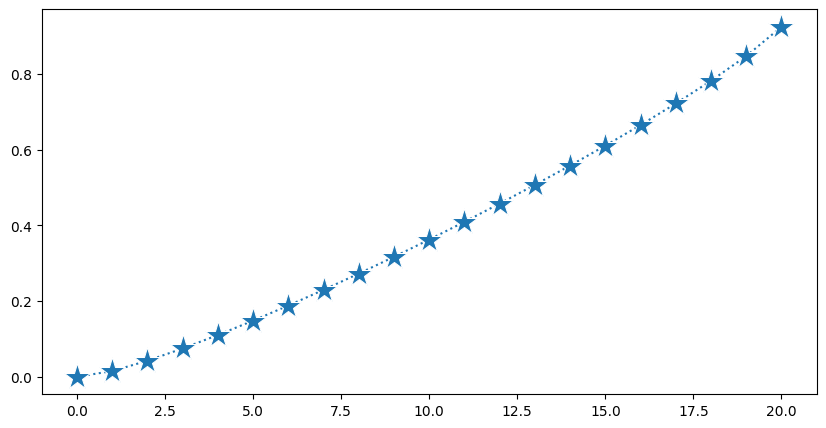

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.subplots(figsize=(10, 5))
sns.lineplot(x=range(num_votes+1), y=scores, linestyle='dotted', marker='*', markersize=20)